# Process data

In [8]:
!pip install imgaug

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
import torch
import matplotlib.pyplot as plt
from skimage import io
from mtcnn import MTCNN

# Retrieve raw data

In [2]:
BASE_PATH = "/home/jupyter/data/faces/"

In [22]:
from google.cloud import storage
client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

"""
blobs = bucket.list_blobs()
for blob in blobs:
    print(blob.name)
""";

In [4]:
DATASET = "faces/videos/faces_final.zip"
FILEPATH = "/home/jupyter/data/faces/faces_final.zip"
blob = bucket.get_blob(DATASET)
blob.download_to_filename(FILEPATH)
# faces.zip should have the following structure: class/video.xyz

In [5]:
!mkdir -p /home/jupyter/data/faces/videos
!unzip -o /home/jupyter/data/faces/faces_final.zip -d /home/jupyter/data/faces/videos
!rm -r /home/jupyter/data/faces/videos/__MACOSX

Archive:  /home/jupyter/data/faces/faces_final.zip
  inflating: /home/jupyter/data/faces/videos/__MACOSX/._Kjartan  
  inflating: /home/jupyter/data/faces/videos/Kjartan/IMG_0036.MOV  
  inflating: /home/jupyter/data/faces/videos/__MACOSX/Kjartan/._IMG_0036.MOV  
  inflating: /home/jupyter/data/faces/videos/Kjartan/IMG_0022.MOV  
  inflating: /home/jupyter/data/faces/videos/__MACOSX/Kjartan/._IMG_0022.MOV  
  inflating: /home/jupyter/data/faces/videos/Kjartan/IMG_0026.MOV  
  inflating: /home/jupyter/data/faces/videos/__MACOSX/Kjartan/._IMG_0026.MOV  
  inflating: /home/jupyter/data/faces/videos/Kjartan/IMG_0030.MOV  
  inflating: /home/jupyter/data/faces/videos/__MACOSX/Kjartan/._IMG_0030.MOV  
  inflating: /home/jupyter/data/faces/videos/Kjartan/IMG_0038.MOV  
  inflating: /home/jupyter/data/faces/videos/__MACOSX/Kjartan/._IMG_0038.MOV  
  inflating: /home/jupyter/data/faces/videos/__MACOSX/._Lars  
  inflating: /home/jupyter/data/faces/videos/Lars/.DS_Store  
  inflating: /home/jupy

# Testing

(224, 224, 3)


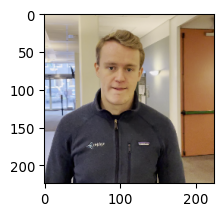

In [9]:

# Read input image
vidcap = cv2.VideoCapture("/home/jupyter/data/faces/videos/Morgan/IMG_0039.MOV")
success, image = vidcap.read()

# Convert to grayscale
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h,w, _ = gray.shape # 1080x1920 (rotated 90deg left)

# Rotate
#gray = np.reshape(gray, (h, w, 1))
gray = np.array(np.rot90(gray, k=3))


# Crop to square
crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
cropped = crop(image=gray)

# Downsize
img_size = 224
resized = cv2.resize(cropped, (img_size, img_size))
#resized = np.reshape(resized, (img_size, img_size, 1))
print(resized.shape)

ia.imshow(resized)

images = [gray, cropped]
#ia.imshow(ia.draw_grid(images, cols=len(images), rows=1))

Augmented:


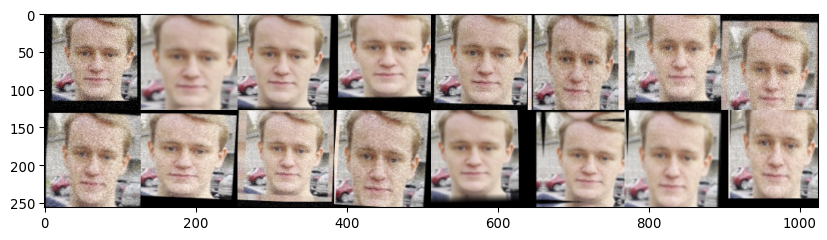

In [19]:
#image = resized

image = cv2.imread("/home/jupyter/data/faces/images/sampling_crop/Morgan/morgan_2213.jpg", cv2.IMREAD_COLOR)

seq = iaa.Sequential([
    iaa.Affine(rotate=(-5, 5)),
    iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 0)), # crop images by -5% to 10% of their height/width
    iaa.AdditiveGaussianNoise(scale=(0, 20)), 
    iaa.GaussianBlur(sigma=(0, 1.0)), # Blur images using a gaussian kernel with sigma between 0.0 and 1.0.
    iaa.Add((-10,10)), # change brightness of images (by -10 to 10 of original value)
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, cval=(0,0)) # translate by -10 to +10 percent (per axis)
], random_order=True)


images_aug = [seq(image=image) for _ in range(16)] # random order is sampled once per batch, and not once per image in the batch
rows=2
print("Augmented:")

ia.imshow(ia.draw_grid(images_aug, cols=len(images_aug)/rows, rows=rows))

In [29]:
!pip install mtcnn
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4 MB 12 kB/s s eta 0:00:01
     |████████████████████████████████| 127 kB 53.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 3.9 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 1.4 MB/s  eta 0:00:01
     |████████████████████████████████| 10.6 MB 46.8 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 55.0 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 779 kB 57.1 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=d6d0cddfcf6ca7852960870528f767251d4d4f4edf91ef86a0a3aa75ecdb5251
  Stored in directory: /home/jupyter/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor


In [3]:
from tensorflow.image import crop_to_bounding_box
def crop_by_bounding_box(img, detector, vertical_expand=0.05, draw=False):
    result = detector.detect_faces(img)
    if len(result) == 0:
        return None
    bounding_box = result[0]['box']
    
    if draw:
        before = img.copy()
        cv2.rectangle(img,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (255,255,255),
                  10)

    y = bounding_box[1]
    x = bounding_box[0]
    height = bounding_box[3]
    width = bounding_box[2]

    # Account for top left corner outside image
    if y < 0:
        height += y
        y = 0
    if x < 0:
        width += x
        x = 0

    # Expand bounding box vertically by vertical_expand % in each direction
    # Move y-coord of top-left corner upwards
    old_y = y
    y = max(y - int(vertical_expand * height), 0)
    height += (old_y - y)

    # Increase height of bounding box
    h, w, _ = img.shape
    height = min(int((1 + vertical_expand) * height), h)
    #print(width, height)
    # Fill horizontally or vertically until width = height
    if height > width:
        if height > w:
            x = 0
            width = w
        else:
            diff_to_fill = height - width

            # Fill leftwards
            old_x = x
            x = max(0, x - int(diff_to_fill / 2))
            x_change = (old_x - x)
            diff_to_fill -= x_change
            width += x_change

            # Fill rightwards
            width = min(width + diff_to_fill, w - x)
    else:
        diff_to_fill = width - height
        # Fill upwards
        old_y = y
        y = max(0, y - int(diff_to_fill/2))
        y_change = (old_y - y)
        diff_to_fill -= y_change
        height += y_change

        # Fill downwards
        height += min(height + diff_to_fill, h - y)
    #print(width, height)
    # Cut height if larger than width
    if height > w:
        diff = height - w
        y += int(diff/2)
        height -= diff
        #height -= height 

    #print(bounding_box)
    #print(x,y,width,height)
    crop = crop_to_bounding_box(img, y, x, height, width).numpy()

    if draw: 
        images = [before, img, crop]
        plt.imshow(ia.draw_grid(images, cols=len(images), rows=1))
    return crop



In [4]:
detector = MTCNN()

(1023, 1023, 3)


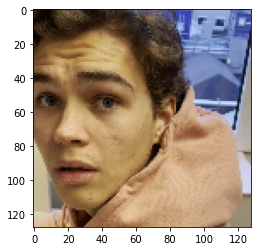

In [44]:
vidcap = cv2.VideoCapture("/home/jupyter/data/faces/videos/Lars/IMG_0004.MOV")
vidcap.set(cv2.CAP_PROP_POS_FRAMES, 0)
success, img = vidcap.read()

img = np.rot90(img, k=3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

res = crop_by_bounding_box(img, detector, vertical_expand=0.1, draw=False)
print(res.shape)
resized = cv2.resize(res, (128, 128)) / 255.0
plt.imshow(resized)


# Extract images

In [5]:
def preprocess_image(img, img_size=None, gray=False, crop=False, rotate=False):
   
    # Rotate image 270 degrees to the right
    if rotate:
        img = np.rot90(img, k=3)
    
    if gray:
        # Convert to grayscale
        # Note: we convert from BGR as VideoCapture 
        # converts the images to BGR color frame by default
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    # Crop to square image
    if crop:
        h, w, _ = img.shape
        crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
        img = crop(image=img)
    
    if img_size is not None:
        # Resize image to specified size
        #img = cv2.resize(img, (img_size, img_size)) / 255.0
        img = cv2.resize(img, (img_size, img_size))
        if gray:
            img = np.reshape(img, (img_size, img_size, 1))
    
    return img

def face_det_process(img, face=True, img_size=64):
   
    # Rotate image 270 degrees to the right
    img = np.rot90(img, k=3)
    
    # Convert to grayscale
    # Note: we convert from BGR as VideoCapture 
    # converts the images to BGR color frame by default
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if not face:
        # Crop to square image
        h, w, _ = img.shape
        crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
        img = crop(image=img)
    
    else:        
        # Find face and crop around
        crop = crop_by_bounding_box(img, detector, vertical_expand=0.1, draw=False)
        if crop is None:
            h, w, _ = img.shape
            crop_aug = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
            img = crop_aug(image=img)
        else:
            img = crop
    
    # Resize image to specified size
    #img = cv2.resize(img, (img_size, img_size)) / 255.0
    #img = cv2.resize(img, (img_size, img_size))
    #img = np.reshape(img, (img_size, img_size, 1))
    
    return img

In [6]:
def max_label(name, folder):
    # Find maximum label of files named as "name_##.jpg" in directory
    highest = 0
    if not os.path.isdir(folder):
        return highest
    for file in os.listdir(folder):
        if name.lower() not in file:
            continue
        label = file.rpartition(os.sep)[2].split(".")[0].rpartition("_")[2]
        highest = max(highest, int(label))
    return highest

In [7]:
def extract_images_from_video(video, target_dir, file_prefix, img_size=64, processing_func=preprocess_image, silent=False):    
    """
    Saves every single frame of a video as images.
    Converts to greyscale, pads with black to make square images and resizes.
    """    
    vidcap = cv2.VideoCapture(video)
    
    video_name = video.rpartition(os.sep)[2].split(".")[0]
    
    # Where to save images    
    os.makedirs(target_dir, exist_ok=True)
    

    prev_label = max_label(file_prefix, target_dir)
    label = prev_label
    face = not video_name.startswith("not_face")
    
    while True:
        # Read image from video
        success, image = vidcap.read()
        
        # if frame is read correctly, succes is True
        if not success:
            if not silent:
                print("Can't receive frame (stream end?). Exiting ...")
            return label - prev_label
        
        # Convert to greyscale, make square and resize
        image = processing_func(image, face)

        # Save to file
        label += 1
        file_name = f"{file_prefix}_{str(label)}.jpg"
        path = os.path.join(target_dir, file_name)
        cv2.imwrite(path, image)

        # Check that image is not corrupted
        if cv2.imread(path) is None:
            print(f"WARNING: image corrupted at path {path}")
            os.remove(path)
        else:
            if not silent:
                print(f'Image successfully written at {path}')


In [11]:
KJARTAN = BASE_PATH + "videos/Kjartan"
LARS = BASE_PATH + "videos/Lars"
MORGAN = BASE_PATH + "videos/Morgan"
OTHER = BASE_PATH + "videos/Other"

LABELS = {LARS: 0, MORGAN: 1, KJARTAN: 2, OTHER: 3}
counts = {KJARTAN: 0, LARS: 0, MORGAN: 0, OTHER: 0}
IMAGE_SIZE = 128

# For each class, extract all frames from all videos, preprocess image and save to target_dir
for label in LABELS:
    if label in [LARS, MORGAN]: # Skip the first to classes, already done
        continue
    count = 0
    video_num = 0
    for video in tqdm(os.listdir(label)):
        if not video.endswith(".MOV"):
            continue
        # Extract each frame of video, preprocess and save to directory
        name = label.rpartition("/")[2]
        target_dir = f"/home/jupyter/data/faces/images/crop_no_resize/{name}"
        video_path = os.path.join(label, video)
        count += extract_images_from_video(video_path, target_dir, file_prefix=name.lower()+f"_video_{video_num}", processing_func=face_det_process, img_size=IMAGE_SIZE, silent=True)
        video_num+=1

    counts[label] = count
    

print(f"Kjartan: {counts[KJARTAN]}, Lars: {counts[LARS]}, Morgan: {counts[MORGAN]}, Other: {counts[OTHER]}")


 14%|█▍        | 1/7 [08:26<50:36, 506.08s/it]


KeyboardInterrupt: 

# Resize and sample images
- At this point we have all cropped images in their original square size in `images/crop_no_resize`
- Now we resize and sample the images before augmenting

In [ ]:
path = BASE_PATH + "images/crop_no_resize/"
target = BASE_PATH + "balanced_images/sampling_crop_224/"

IMAGE_SIZE = 224

images = {}
sizes = []

for label in LABELS:
    images[label] = []
    for image_file in os.listdir(path + label):
        images.append(os.path.join(path + label, image_file))
    sizes.append(len(images[label]))
    print(label, len(images))
min_sample_size = min(sizes)
print("Minimum sample size: ": min_sample_size)

print(f"Sampling and resizing {min_sample_size} images from each class to {target}...")
for label in LABELS:
    sample = np.random.choice(images[label], min_sample_size, replace=False)
    target_path = target + label
    for image_path in tqdm(sample):        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        os.makedirs(target_path, exist_ok=True)
        cv2.imwrite(os.path.join(target_path, image_path.rpartition(os.sep)[2]), image)

# Augment images

In [46]:
def augment_image(image, num_augmentations=19):
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-5, 5)),
        iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 255)), # crop images by -5% to 10% of their height/width
        iaa.AdditiveGaussianNoise(scale=(0, 20)), 
        iaa.GaussianBlur(sigma=(0, 1.0)), # Blur images using a gaussian kernel with sigma between 0.0 and 1.0.
        iaa.Add((-10,10)), # change brightness of images (by -10 to 10 of original value)
        iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, cval=(0,255)) # translate by -10 to +10 percent (per axis)
    ], random_order=True)

    
    images_aug = [seq(image=image) for _ in range(num_augmentations)] # random order is sampled once per batch, and not once per image in the batch
    return images_aug

def augment_and_save(image_path, target_dir, num_augmentations=19, silent=False):
    # Read image from file
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    #h, w, _ = image.shape
    #image = np.reshape(1, h, w)
    
    #image = preprocess_image(image, img_size=224, gray=False, crop=False, rotate=False)

    
    # Generate augmentations
    augmentations = augment_image(image, num_augmentations)
    augmentations.insert(0, image)
    #for i, image in enumerate(augmentations):
    #    augmentations[i] = image / 255.0 # <-- creates black images upon imwrite (uint8 conversion)
    count = len(augmentations)
    
    os.makedirs(target_dir, exist_ok=True)

    # Save augmentations to file
    for i, img in enumerate(augmentations):
        path = os.path.join(target_dir, image_path.rpartition(os.sep)[2].split(".")[0]) + f"_augmentation_{i}.jpg"
        cv2.imwrite(path, img)
        
        # Check that image is not corrupted
        if cv2.imread(path) is None:
            print(f"WARNING: image corrupted at path {path}")
            os.remove(path)
            count -=1
            count = 0 if count<0 else count
        else:
            if not silent:
                print(f'Image successfully written at {path}')
    return count
    

In [52]:
KJARTAN = "Kjartan"
LARS = "Lars"
MORGAN = "Morgan"
OTHER = "Other"

LABELS = {LARS: 0, MORGAN: 1, KJARTAN: 2, OTHER: 3}
counts = {KJARTAN: 0, LARS: 0, MORGAN: 0, OTHER: 0}
N_AUGMENTATIONS = 19

# For each processed image, generate 19 augmentations and save to augmented_images
for label in LABELS:
    if label != MORGAN:
        continue
    count = 0
    path = f"{BASE_PATH}balanced_images/sampling_crop_224/{label}"
    for image in tqdm(os.listdir(path)):
        if not image.endswith(".jpg"):
            continue
        image_path = os.path.join(path, image)
        target_dir = f"{BASE_PATH}augmented_images/sampling_crop_224/{label}"
        count += augment_and_save(image_path, target_dir, num_augmentations=N_AUGMENTATIONS, silent=True)
    counts[label] += count
    

print(f"Kjartan: {counts[KJARTAN]}, Lars: {counts[LARS]}, Morgan: {counts[MORGAN]}, Other: {counts[OTHER]}")

100%|██████████| 3168/3168 [07:52<00:00,  6.70it/s]

Kjartan: 0, Lars: 0, Morgan: 40960, Other: 0


# Split dataset

In [56]:
from sklearn.model_selection import train_test_split


path = BASE_PATH + "augmented_images/sampling_crop_224/"

training_data = []
training_labels = []

print("Collecting images...")
for label in LABELS:
    for image_file in tqdm(os.listdir(path + label)):
        image_path = os.path.join(path + label, image_file)
        training_data.append(image_path)
        training_labels.append(label)


X = np.array(training_data)
y = np.array(training_labels)

# 70/15/15 train/val/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, shuffle=True)

print(X_train.shape, X_val.shape, X_train.shape) # Should be (n, 224, 224, 3)



  0%|          | 33/39060 [00:00<01:58, 328.29it/s]

Lars 62460


  0%|          | 14/39060 [00:00<05:55, 109.93it/s]

Morgan 63360


  0%|          | 2/39060 [00:00<35:06, 18.54it/s]

Kjartan 39060


  0%|          | 3/39060 [00:00<27:10, 23.95it/s]

Other 111980


100%|██████████| 39060/39060 [16:24<00:00, 39.69it/s]


In [64]:
import shutil

target = f"{BASE_PATH}sampled_dataset_balanced_cropped_224/"
print(f"Copying images from {path} to {target}")

dataset = {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)}
for mode in dataset:
    path = os.path.join(target, mode)
    images, labels = dataset[mode]
    for i, image_path in tqdm(enumerate(images)):
        target_dir = os.path.join(path, labels[i])
        os.makedirs(target_dir, exist_ok=True)
        shutil.copy(image_path, target_dir)
        

109368it [25:04, 72.71it/s] 
23436it [08:21, 46.74it/s]
23436it [08:27, 46.15it/s]


# Compress images and upload to Cloud Storage

In [66]:
!cd /home/jupyter/data/faces && zip -r -q balanced_sampled_cropped_224px_color_70_15_15_split.zip sampled_dataset_balanced_cropped_224

In [ ]:
cloud_directory = "faces/balanced_sampled_cropped_224px_color_70_15_15_split.zip"
blob = bucket.blob(cloud_directory)

source_file_name = BASE_PATH + "balanced_sampled_cropped_224px_color_70_15_15_split.zip"
blob.upload_from_filename(source_file_name)

# Done! Below cells are old and not needed atm

# Save images to Cloud Storage

In [89]:
!zip -r /home/jupyter/data/faces/images_final_128px_color.zip /home/jupyter/data/faces/images

  adding: home/jupyter/data/faces/images/ (stored 0%)
  adding: home/jupyter/data/faces/images/.ipynb_checkpoints/ (stored 0%)
  adding: home/jupyter/data/faces/images/Train/ (stored 0%)
  adding: home/jupyter/data/faces/images/Train/.ipynb_checkpoints/ (stored 0%)
  adding: home/jupyter/data/faces/images/Train/Other/ (stored 0%)
  adding: home/jupyter/data/faces/images/Train/Other/other_2030.jpg (deflated 2%)
  adding: home/jupyter/data/faces/images/Train/Other/other_840.jpg (deflated 2%)
  adding: home/jupyter/data/faces/images/Train/Other/other_3126.jpg (deflated 1%)
  adding: home/jupyter/data/faces/images/Train/Other/other_832.jpg (deflated 2%)
  adding: home/jupyter/data/faces/images/Train/Other/other_931.jpg (deflated 2%)
  adding: home/jupyter/data/faces/images/Train/Other/other_829.jpg (deflated 2%)
  adding: home/jupyter/data/faces/images/Train/Other/other_250.jpg (deflated 2%)
  adding: home/jupyter/data/faces/images/Train/Other/other_998.jpg (deflated 2%)
  adding: home/jup

In [109]:
!zip -r -q /home/jupyter/data/faces/augmented_images_final_128px_color.zip /home/jupyter/data/faces/augmented_images

In [111]:
"""
cloud_directory = "faces/images/images_final_128px_color.zip"
blob = bucket.blob(cloud_directory)

source_file_name = BASE_PATH + "images_final_128px_color.zip"
blob.upload_from_filename(source_file_name)
"""
cloud_directory = "faces/augmented_images/augmented_images_final_128px_color.zip"
blob = bucket.blob(cloud_directory)

source_file_name = BASE_PATH + "augmented_images_final_128px_color.zip"
blob.upload_from_filename(source_file_name)


# Create tensor from augmented images

In [243]:
KJARTAN = BASE_PATH + "augmented_images/Kjartan"
LARS = BASE_PATH + "augmented_images/Lars"
MORGAN = BASE_PATH + "augmented_images/Morgan"
OTHER = BASE_PATH + "augmented_images/Other"

LABELS = {LARS: 0, MORGAN: 1, OTHER: 2, KJARTAN: 3}

image_paths = []
for label in LABELS:
    count = 0
    for image_file in tqdm(os.listdir(label)):
        if not image_file.endswith(".jpg"):
            continue
        
        image_path = os.path.join(label, image_file)
        image_paths.append((image_path, label))

        
np.random.shuffle(image_paths)

training_data = []
training_labels = []
for image_path, label in tqdm(image_paths):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h,w = image.shape
    image = np.reshape(image, (1, h, w))
    training_data.append(image)
    training_labels.append(LABELS[label])
    

save_file_name = os.path.join(BASE_PATH, f"lars_morgan_other_augments_{IMAGE_SIZE}px_{len(training_data)}.torch")

print("Saving torch object to file")
torch.save(
    {
        #"x": torch.Tensor(training_data).view(-1, IMAGE_SIZE, IMAGE_SIZE) / 255.0,
        "x": torch.Tensor(training_data) / 255.0,
        "y": torch.Tensor(training_labels).to(torch.int64),
        "num_classes": 3,
    },
    save_file_name,
)

print("Done!")


100%|██████████| 50861/50861 [00:00<00:00, 461310.31it/s]
0it [00:00, ?it/s]
100%|██████████| 110120/110120 [00:13<00:00, 8464.58it/s]


Saving torch object to file
Done!


In [245]:
cloud_directory = "faces/tensors/" + f"lars_morgan_other_augments_{IMAGE_SIZE}px_{len(training_data)}.torch"
blob = bucket.blob(cloud_directory)

source_file_name = save_file_name
blob.upload_from_filename(source_file_name)

# Notes for data collection

- Currently every single frame of the video is used, so each frame needs to contain the face of the person
- All videos should use the same camera settings (resolution etc)
- Should film with as low resolution as possible
- Low framerate is probably ideal
- When saving videos, store them as `folder/Class/video.mp4` and zip `folder`